# Atlas-scale Analysis: a cell atlas of human chromatin accessibility.

## Introduction

In this tutorial, we will delve into a substantial dataset that forms a human single-cell atlas of chromatin accessibility. The atlas consists of 92 scATAC-seq samples, encompassing approximately 650,000 cells.

In [1]:
import snapatac2 as snap
import numpy as np
import os
from tqdm import tqdm

snap.__version__

'2.3.2dev1'

The fragment files required for this tutorial can be downloaded here: http://catlas.org/catlas_downloads/humantissues/fragment/.

After the files have been downloaded, place the files in a directory and save its path to variable called `data_dir`.

In [2]:
data_dir = "/home/kaizhang/renlab2/project/Atlas/Zhang_Cell_2021/Fragment"
output_dir = "h5ad_output"
os.makedirs(output_dir, exist_ok=True)

In [3]:
fragment_files = [f'{data_dir}/{fl}' for fl in os.listdir(data_dir) if fl.endswith(".bed.gz")]

## Preprocessing

To begin importing the data, we provide a list of files to `snap.pp.import_data`. Keep in mind that if you supply a list of input files, you should also pass a corresponding list of output files to the file parameter, unless you opt for using an in-memory AnnData object. However, storing a large number of AnnData objects in memory can consume significant resources and is generally not recommended for analysese at such scales.

Note that you can control the number of CPUs utilized by setting the `n_jobs` parameter, which defaults to 8. You don't need to allocate an excessive number of CPUs, as this function is primarily I/O-bound.

In [4]:
%%time
outputs = []
for fl in fragment_files:
    name = fl.split('/')[-1].split('.bed.gz')[0]
    outputs.append(f'{output_dir}/{name}.h5ad')

adatas = snap.pp.import_data(fragment_files, file=outputs, genome=snap.genome.hg38,
                             min_num_fragments=1000, min_tsse=7)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [19:59<00:00, 13.04s/it]


CPU times: user 913 ms, sys: 2.12 s, total: 3.03 s
Wall time: 20min 5s


We will now perform cell-by-bin matrix generation, feature selection, and doulet removal.

In [5]:
%%time
snap.pp.add_tile_matrix(adatas, bin_size=5000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [08:33<00:00,  5.58s/it]


CPU times: user 827 ms, sys: 1.91 s, total: 2.74 s
Wall time: 8min 39s


In [6]:
%%time
snap.pp.select_features(adatas)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:23<00:00,  1.10it/s]


CPU times: user 933 ms, sys: 1.41 s, total: 2.35 s
Wall time: 1min 30s


In [ ]:
%%time
snap.pp.scrublet(adatas)
snap.pp.filter_doublets(adatas)

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 77/92 [55:18<07:25, 29.72s/it]

## Dimensionality reduction

We now concatenate all AnnData objects to form a AnnDataSet object.

In [8]:
adataset = snap.AnnDataSet(
    adatas=[(f.filename.split('/')[-1].split('.h5ad')[0], f) for f in adatas],
    filename="data.h5ads"
)
# Make the obs_names unique by adding sample names to barcodes
adataset.obs_names = np.array(adataset.obs['sample']) + '+' + np.array(adataset.obs_names)
adataset

AnnDataSet object with n_obs x n_vars = 645353 x 606219 backed at 'data.h5ads'
contains 92 AnnData objects with keys: 'thyroid:SM-IOBHW_1', 'skin_sun_exposed:SM-IOBHU_1', 'heart_lv:CARE190307_10D_1', 'adipose_omentum:SM-CHZRM_1', 'esophagus_muscularis:SM-CSSCV_1', 'pancreas:SM-IOBHS_1', 'stomach:SM-CHLWL_1', 'artery_tibial:SM-IOBHK_1', 'stomach:SM-JF1O3_1', 'pancreas:SM-JF1NS_1', 'heart_la:CARE190307_10C_1', 'skin_sun_exposed:SM-ADYHK_1', 'lung:SM-JF1NZ_1', 'adipose_omentum:SM-ADYHB_1', 'heart_atrial_appendage:SM-JF1NX_1', 'heart_lv:CARE191122_2D_1', 'esophagus_muscularis:SM-IOBHM_1', 'pancreas:SM-JF1O6_1', 'islet:CB2_1', 'heart_lv:CARE191122_3D_1', 'muscle:SM-C1PWV_1', 'heart_la:CARE191122_2C_1', 'frontal_cortex:UMB4540_2', 'skin:SM-JF1O1_1', 'colon_transverse:SM-ACCQ1_1', 'colon_transverse:SM-A9HOW_1', 'heart_rv:CARE190307_10B_1', 'islet:CB1_1', 'heart_ra:CARE190307_10A_1', 'muscle:SM-ADA6L_1', 'frontal_cortex:UMB4540_1', 'heart_rv:CARE181213_2B_1', 'esophagus_mucosa:SM-A9VPA_1', 'sm

In [9]:
%%time
snap.pp.select_features(adataset, n_features=250000)
snap.tl.spectral(adataset)

2023-09-08 14:42:13 - INFO - Selected 250000 features.


CPU times: user 16min 56s, sys: 1min 8s, total: 18min 4s
Wall time: 15min 16s


## Batch correction

In this dataset, which includes samples from multiple donors, it's important to correct for donor-specific effects. To accomplish this, we employ the `snap.pp.mnc_correct` function for batch correction. We opt not to adjust for effects at the tissue level, as doing so could potentially eliminate meaningful inter-tissue differences for certain cell types, such as fibroblasts. To selectively correct for donor effects while preserving tissue-level differences, we use the `groupby` parameter. This parameter instructs SnapATAC2 to first segregate the cells into separate groups based on the specified criteria, and then perform batch correction within each of these groups independently.

In [11]:
%%time
# Store tissue types in .obs
adataset.obs['tissue'] = [x.split(':')[0] for x in adataset.obs['sample']]
snap.pp.mnc_correct(adataset, batch="sample", groupby='tissue', key_added='X_spectral')

## Clustering

In [12]:
%%time
snap.pp.knn(adataset)
snap.tl.leiden(adataset)

CPU times: user 17min 35s, sys: 1min 3s, total: 18min 39s
Wall time: 5min 24s


## Visualization

In [23]:
snap.tl.umap(adataset, n_comps=3)

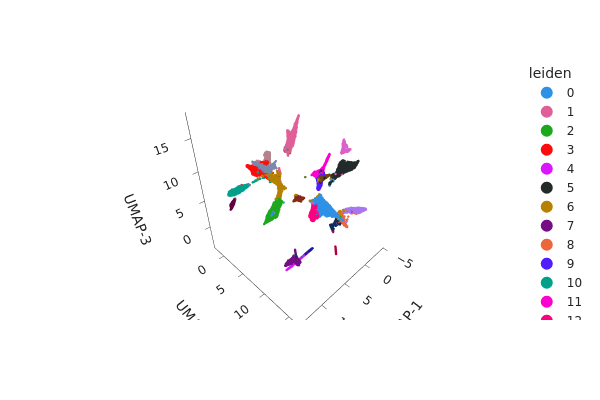

In [27]:
# Note you can remove `interactive=False` to return an interactive plot
snap.pl.umap(adataset, color="leiden", interactive=False)

## Subclustering

Certain cell types identified through previous clustering may still contain heterogeneous subpopulations. To further dissect this heterogeneity, we can perform subclustering on selected populations.

To facilitate this, let's first load the on-disk AnnData structure into memory to make subsetting more convenient.

In [13]:
%%time
adata = adataset.to_adata()
adata

In [22]:
adata_c0 = adata[adata.obs['leiden'] == '0'].copy()
adata_c0

AnnData object with n_obs × n_vars = 56078 × 606219
    obs: 'sample', 'tissue', 'leiden'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'AnnDataSet', 'reference_sequences'
    obsm: 'X_spectral'
    obsp: 'distances'

We then proceed to perform clustering analysis on the subset of the data.

In [23]:
%%time
snap.pp.select_features(adata_c0, n_features=250000)
snap.tl.spectral(adata_c0)
snap.pp.mnc_correct(adata_c0, batch="sample", groupby='tissue', key_added='X_spectral')

2023-09-08 15:25:42 - INFO - Selected 250000 features.


CPU times: user 3min 43s, sys: 11.2 s, total: 3min 54s
Wall time: 1min 7s


In [29]:
%%time
snap.pp.knn(adata_c0)
snap.tl.leiden(adata_c0)
snap.tl.umap(adata_c0)

CPU times: user 2min 8s, sys: 4.6 s, total: 2min 13s
Wall time: 1min 5s


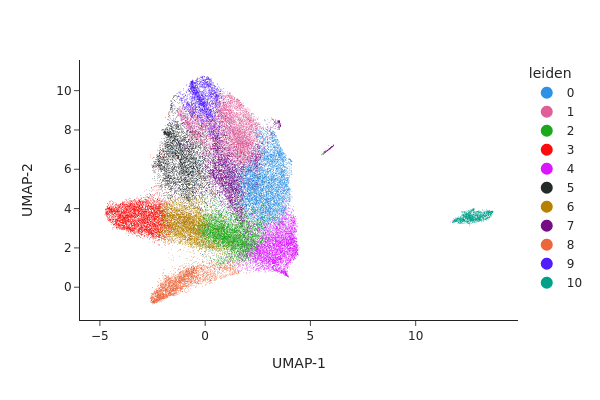

In [30]:
snap.pl.umap(adata_c0, color="leiden", interactive=False)

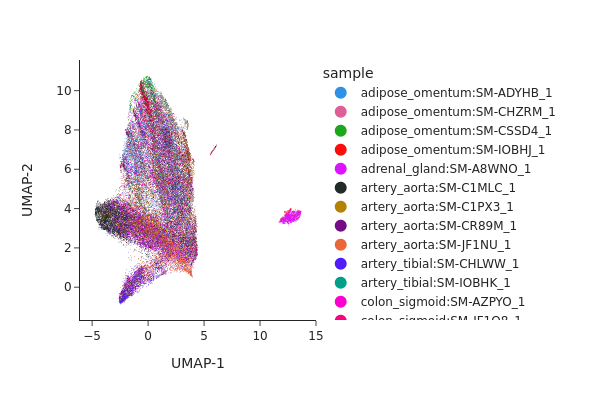

In [31]:
snap.pl.umap(adata_c0, color="sample", interactive=False)